# Data Acquisition and Preparation:

Importing necessary libraries like Pandas and scikit-learn for data manipulation and modelling

In [134]:
import pandas as pd
import numpy
import re
from sklearn import *
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Loading in the database

In [135]:
df = pd.read_csv("openpowerlifting.csv")
df.head()

C:\Users\PC\AppData\Local\Temp\ipykernel_22748\631813537.py:1: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("openpowerlifting.csv")


,Name,Sex,Event,Equipment,Age,AgeClass,Division,BodyweightKg,WeightClassKg,Squat1Kg,...,McCulloch,Glossbrenner,IPFPoints,Tested,Country,Federation,Date,MeetCountry,MeetState,MeetName
0,Abbie Murphy,F,SBD,Wraps,29.0,24-34,F-OR,59.8,60,80.0,...,324.16,286.42,511.15,NaN,NaN,GPC-AUS,2018-10-27,Australia,VIC,Melbourne Cup
1,Abbie Tuong,F,SBD,Wraps,29.0,24-34,F-OR,58.5,60,100.0,...,378.07,334.16,595.65,NaN,NaN,GPC-AUS,2018-10-27,Australia,VIC,Melbourne Cup
2,Ainslee Hooper,F,B,Raw,40.0,40-44,F-OR,55.4,56,NaN,...,38.56,34.12,313.97,NaN,NaN,GPC-AUS,2018-10-27,Australia,VIC,Melbourne Cup
3,Amy Moldenhauer,F,SBD,Wraps,23.0,20-23,F-OR,60.0,60,-105.0,...,345.61,305.37,547.04,NaN,NaN,GPC-AUS,2018-10-27,Australia,VIC,Melbourne Cup
4,Andrea Rowan,F,SBD,Wraps,45.0,45-49,F-OR,104.0,110,120.0,...,338.91,274.56,550.08,NaN,NaN,GPC-AUS,2018-10-27,Australia,VIC,Melbourne Cup


## Data Exploration 

In [136]:
df.shape

(1423354, 37)

Looking at the column names

In [137]:
df.columns

Index(['Name', 'Sex', 'Event', 'Equipment', 'Age', 'AgeClass', 'Division',
       'BodyweightKg', 'WeightClassKg', 'Squat1Kg', 'Squat2Kg', 'Squat3Kg',
       'Squat4Kg', 'Best3SquatKg', 'Bench1Kg', 'Bench2Kg', 'Bench3Kg',
       'Bench4Kg', 'Best3BenchKg', 'Deadlift1Kg', 'Deadlift2Kg', 'Deadlift3Kg',
       'Deadlift4Kg', 'Best3DeadliftKg', 'TotalKg', 'Place', 'Wilks',
       'McCulloch', 'Glossbrenner', 'IPFPoints', 'Tested', 'Country',
       'Federation', 'Date', 'MeetCountry', 'MeetState', 'MeetName'],
      dtype='object')

This investigation will use **Best3BenchKg**, **Best3SquatKg** and **Best3DeadliftKg** as measures of strength. Features investigated will be Age, Sex, Previous Bests, etc

In [138]:
# Rows that have SBD
df["Event"].value_counts()["SBD"]

1073237

## Data Cleanining
We only need the rows of people who have competed in the SBD class

In [139]:
sbd_df = df[df["Event"] == "SBD"]
sbd_df.shape

(1073237, 37)

In [140]:
sbd_df["Equipment"].value_counts()

Equipment
Single-ply    659208
Raw           280995
Wraps         102583
Multi-ply      30451
Name: count, dtype: int64

### Handling missing values

In [141]:
sbd_df["Wilks"].isnull().sum()

93727

In [142]:
sbd_df["Best3BenchKg"].isnull().sum()

68162

In [143]:
sbd_df["Best3SquatKg"].isnull().sum()

49371

In [144]:
sbd_df["Best3DeadliftKg"].isnull().sum()

75259

Investigating the source of missingness. This could be due to data entry or lack of data in some of the lift categories

In [145]:
all_missing = sbd_df[sbd_df["Best3DeadliftKg"].isnull() & sbd_df["Best3SquatKg"].isnull() & sbd_df["Best3BenchKg"].isnull()]
all_missing.shape[0]

42783

Calculating each one individually

In [146]:
def fill_best_lifts(df):
    # Define lists of attempt columns for each lift
    lift_cols = {
        "Best3SquatKg": ["Squat1Kg", "Squat2Kg", "Squat3Kg", "Squat4Kg"],
        "Best3BenchKg": ["Bench1Kg", "Bench2Kg", "Bench3Kg", "Bench4Kg"],
        "Best3DeadliftKg": ["Deadlift1Kg", "Deadlift2Kg", "Deadlift3Kg", "Deadlift4Kg"]
    }
    
    # Iterate through lift types and update columns
    for lift_type, attempt_cols in lift_cols.items():
        # Calculate the maximum of the attempt columns
        attempt_max = df[attempt_cols].max(axis=1)
        # Use combine_first to fill NaN values in lift_type column with the calculated max
        df[lift_type] = df[lift_type].combine_first(attempt_max)
    
    return df


sbd_df = fill_best_lifts(sbd_df.copy())

all_missing = sbd_df[sbd_df["Best3DeadliftKg"].isnull() & sbd_df["Best3SquatKg"].isnull() & sbd_df["Best3BenchKg"].isnull()]
all_missing.shape[0]

37221

In [147]:
sbd_df = sbd_df.dropna(subset = ["Best3DeadliftKg", "Best3SquatKg", "Best3BenchKg"], thresh=3)
sbd_df.shape

(997578, 37)

In [148]:
# Competetors should be able to lift the bar
sbd_df = sbd_df[sbd_df["Best3SquatKg"] > 20 ]
sbd_df = sbd_df[sbd_df["Best3BenchKg"] > 20 ]
sbd_df = sbd_df[sbd_df["Best3DeadliftKg"] > 20 ]

In [149]:
sbd_df["TotalKg"].isnull().sum()

2157

In [150]:
def fill_total_kg(df):
    total_dict = {"TotalKg" : ["Best3SquatKg", "Best3BenchKg", "Best3DeadliftKg"]}
    for total, lifts in total_dict.items():
        total_max = df[lifts].sum(axis=1)
        df[total] = df[total].combine_first(total_max)
    return df

sbd_df = fill_total_kg(sbd_df.copy())

sbd_df["TotalKg"].isnull().sum()

0

In [151]:
maow = sbd_df[sbd_df["TotalKg"].isna()]
maow.to_csv("Total_missing.csv")

## Other Factors
In this we are going to use bodyweight , age 

In [152]:
sbd_df["AgeClass"].value_counts()

AgeClass
24-34     156070
20-23      99361
18-19      47050
35-39      36209
40-44      33167
16-17      32936
45-49      22768
13-15      18030
50-54      17238
55-59       9907
60-64       6490
65-69       3611
70-74       2166
5-12        1088
75-79        825
80-999       231
Name: count, dtype: int64

## Handling Outliers

## Looking at the distributions of all lifts

<Axes: >

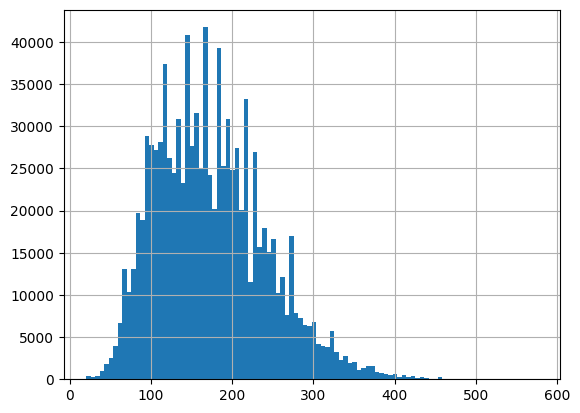

In [153]:
sbd_df["Best3SquatKg"].hist(bins=100)

<Axes: ylabel='Best3SquatKg'>

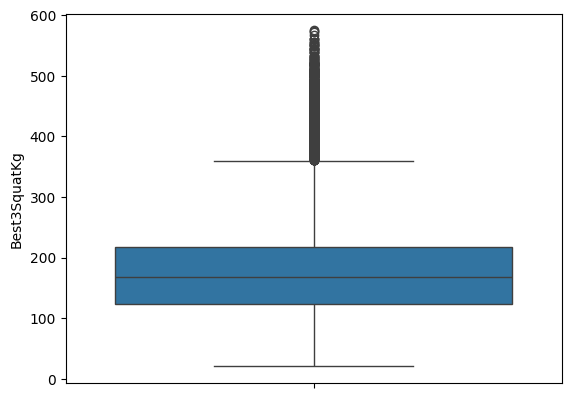

In [154]:
sns.boxplot(sbd_df["Best3SquatKg"])

<Axes: >

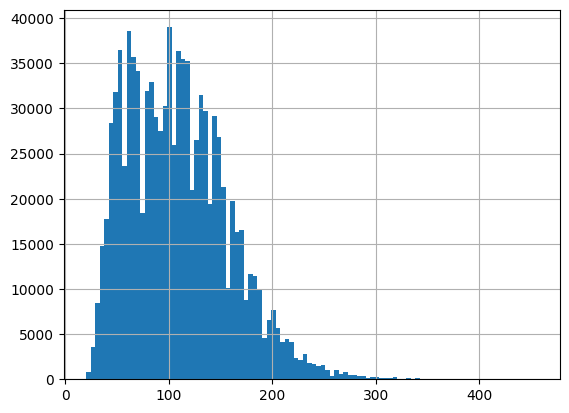

In [155]:
sbd_df["Best3BenchKg"].hist(bins=100)

<Axes: ylabel='Best3BenchKg'>

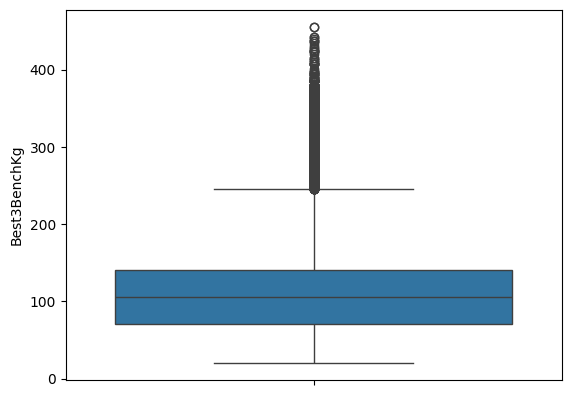

In [156]:
sns.boxplot(sbd_df["Best3BenchKg"])

<Axes: >

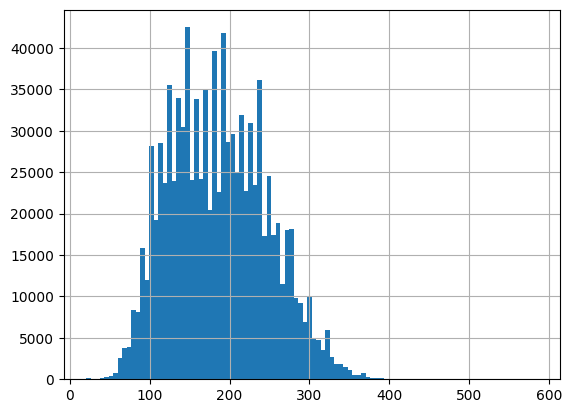

In [157]:
sbd_df["Best3DeadliftKg"].hist(bins=100)

<Axes: ylabel='Best3DeadliftKg'>

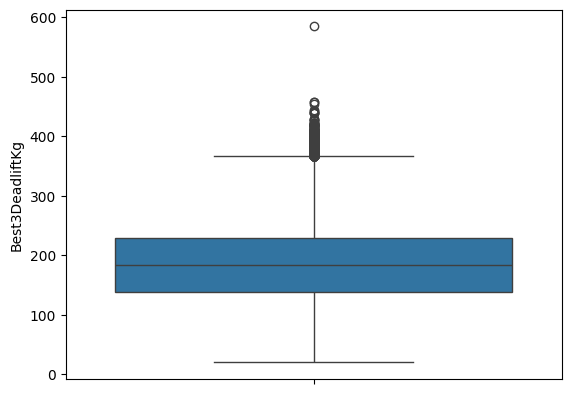

In [158]:
sns.boxplot(sbd_df["Best3DeadliftKg"])

<Axes: ylabel='Best3DeadliftKg'>

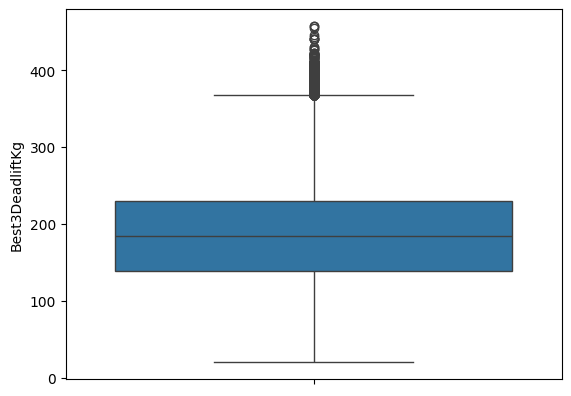

In [159]:
sbd_df = sbd_df[sbd_df["Best3DeadliftKg"] < 500]
sns.boxplot(sbd_df["Best3DeadliftKg"])

<Axes: >

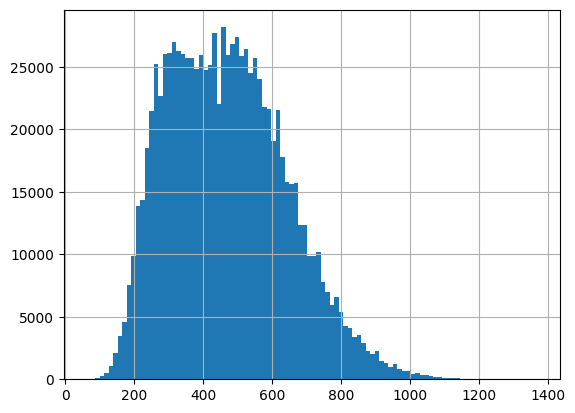

In [160]:
sbd_df["TotalKg"].hist(bins=100)

# Cleaned data
In this piece of code I have
1. Explored the data
2. Calculated missing best lifts and totals
3. Removed Outliers

In [164]:
sbd_df.to_csv("All_Data_Cleaned.csv")
sbd_df.shape

(985059, 37)

In [163]:
No_Equipment_sbd_df = sbd_df[sbd_df["Equipment"].isin(["Raw", "Wraps"])]
sbd_df.to_csv("No_Equpiment_Data_Cleaned.csv")

# Model Training and Evaluation 
Split the data into training and testing sets. The training set helps build the model, and the testing set evaluates its performance on unseen data.

Train different models, starting with a simple one like linear regression. More complex models like Random Forest can be explored later.

Evaluate the performance of each model using metrics like R-squared on the testing set. This helps you understand how well the model predicts the actual totals.

# Model Improvement

Utilize feature selection techniques to identify the most impactful features for predicting total lift. This can involve analyzing feature importance scores from models like Random Forest.

Re-train your models with the selected features and compare their performance to the models trained with all features. This can potentially improve prediction accuracy.
